In [1]:
import glob
import pickle
import tqdm
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import collect_data as colda

In [3]:
Path("plots").mkdir(parents=True, exist_ok=True)

# read data from cache

In [4]:
results_profcov = {}
for tool in colda.TOOLS:
    try:
        results_profcov[tool] = colda.read_from_cache_profcov(tool) 
    except colda.CacheNotFoundError:
        pass

loading 'time' from cache!
 loaded 'time' results for 50 apps and 4 runs from cache!
loading 'monkey' from cache!
 loaded 'monkey' results for 50 apps and 4 runs from cache!
loading 'droidbot' from cache!
 loaded 'droidbot' results for 16 apps and 4 runs from cache!
loading 'fastbot' from cache!
 loaded 'fastbot' results for 50 apps and 4 runs from cache!


In [5]:
results_acvtool = {}
for tool in colda.TOOLS:
    try:
        results_acvtool[tool] = colda.read_from_cache_acvtool(tool)
    except colda.CacheNotFoundError:
        pass

loading 'time' from cache!
 loaded 'time' results for 16 apps and 4 runs from cache!
loading 'monkey' from cache!
 loaded 'monkey' results for 16 apps and 4 runs from cache!
loading 'droidbot' from cache!
 loaded 'droidbot' results for 14 apps and 4 runs from cache!
loading 'fastbot' from cache!
 loaded 'fastbot' results for 16 apps and 4 runs from cache!


# Profile coverage over time - all runs seperate

In [6]:
# see https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot

plt.rcParams.update({'font.size': 12})

def lineplot_relative(results, title):
    ax = sns.lineplot(
            x='seconds since first probe hit',
            y='profile coverage',
            hue='app id',
            units='run id',
            estimator=None,
            data=results,
            legend=False)
    #ax.set_title(title)
    ax.set(xlim=(0,600), ylim=(0,1))
    for line in ax.lines:
        line.set_alpha(0.6)
    ax.set_xlabel("Seconds since first probe hit")
    ax.set_ylabel("Profile Coverage")
    plt.savefig(f"plots/profile-coverage_lineplot_relative_{title}.pdf", bbox_inches='tight')
    plt.savefig(f"plots/profile-coverage_lineplot_relative_{title}.png", bbox_inches='tight')
    #plt.savefig(f"plots/profile-coverage_lineplot_relative_{title}.png", bbox_inches='tight')
    plt.show()

# this takes ~3m to plot

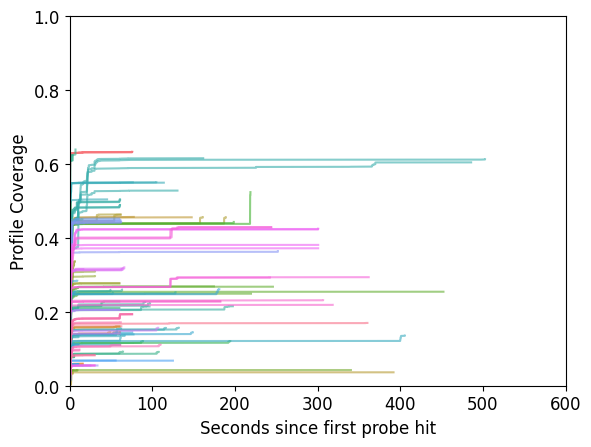

In [7]:
if "time" in results_profcov:
    lineplot_relative(results_profcov['time'], 'baseline')

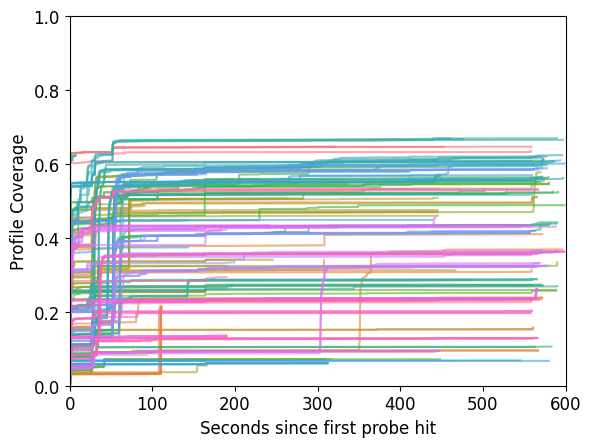

In [8]:
if "monkey" in results_profcov:
    lineplot_relative(results_profcov['monkey'], 'monkey')

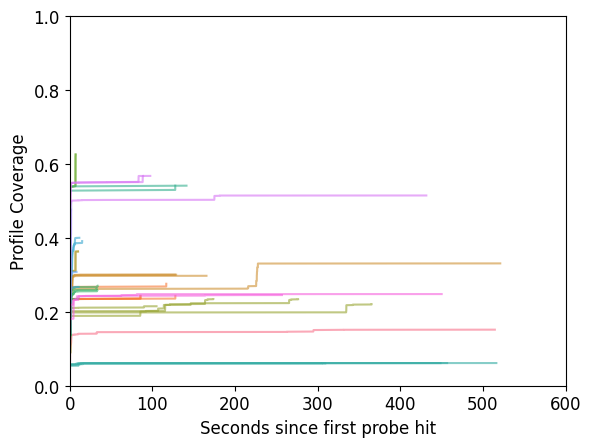

In [9]:
if "droidbot" in results_profcov:
    lineplot_relative(results_profcov['droidbot'], 'droidbot')

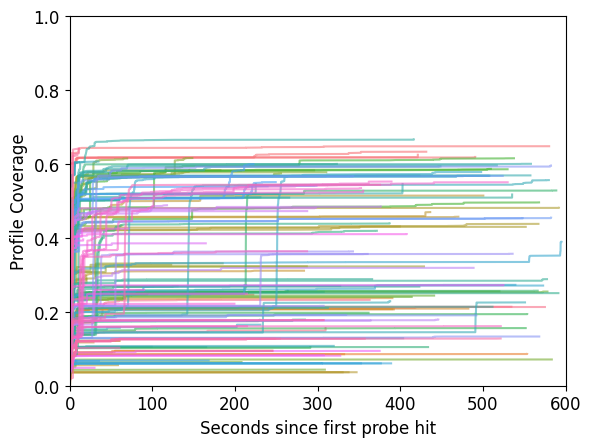

In [10]:
if "fastbot" in results_profcov:
    lineplot_relative(results_profcov['fastbot'], 'fastbot')

# Profile coverage over time - maximum precomputed

In [11]:
def precompute_max(results):
    """
    we precompute the maximum by selecting the run with the highest coverage at any point, not whether it's the last value
    (max can mean highest or longest - we use highest)
    """
    res = {}
    for tool in colda.TOOLS:
        if tool not in results:
            print(f"{tool} not in dataset, skipping")
            continue

        # subframe with only relevant columns
        sf = results[tool][['app id','run id','profile coverage','seconds since first probe hit']].dropna()
        
        # find run id for max
        idx = sf.groupby('app id')['profile coverage'].idxmax()

        max_vals = sf.loc[idx][['app id', 'run id']]

        selection = sf[sf.set_index(['app id', 'run id']).index.isin(max_vals.set_index(['app id', 'run id']).index)]

        res[tool] = selection[['app id', 'profile coverage', 'seconds since first probe hit']].copy()
    return res

results_profcov_precomputed_max = precompute_max(results_profcov)

In [12]:
def lineplot_max(results, title):
    ax = sns.lineplot(
            x='seconds since first probe hit',
            y='profile coverage',
            hue='app id',
            estimator=None,
            data=results,
            legend=False)
    #ax.set_title(title)
    ax.set(xlim=(0,600), ylim=(0,1))
    for line in ax.lines:
        line.set_alpha(0.6)
    ax.set_xlabel("Seconds since first probe hit")
    ax.set_ylabel("Profile Coverage")
    plt.savefig(f"plots/profile-coverage_lineplot_max_{title}.pdf", bbox_inches='tight')
    plt.savefig(f"plots/profile-coverage_lineplot_max_{title}.png", bbox_inches='tight')
    plt.show()

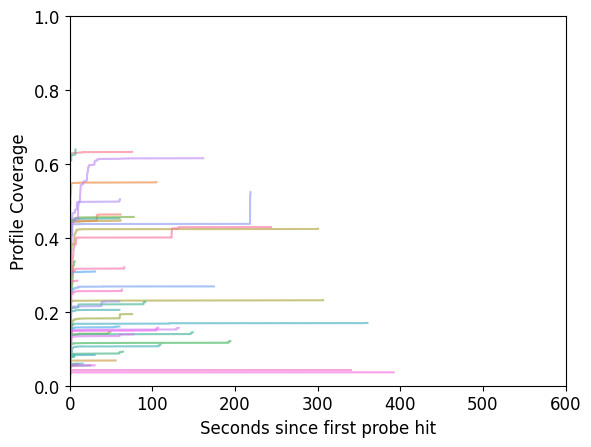

In [13]:
if "time" in results_profcov:
    lineplot_max(results_profcov_precomputed_max['time'], 'baseline')

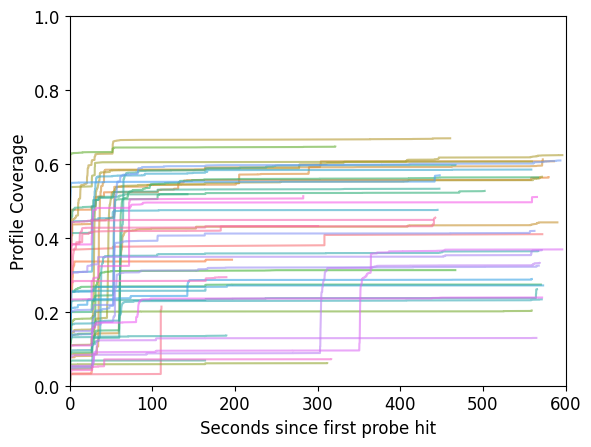

In [14]:
if "monkey" in results_profcov:
    lineplot_max(results_profcov_precomputed_max['monkey'], 'monkey')

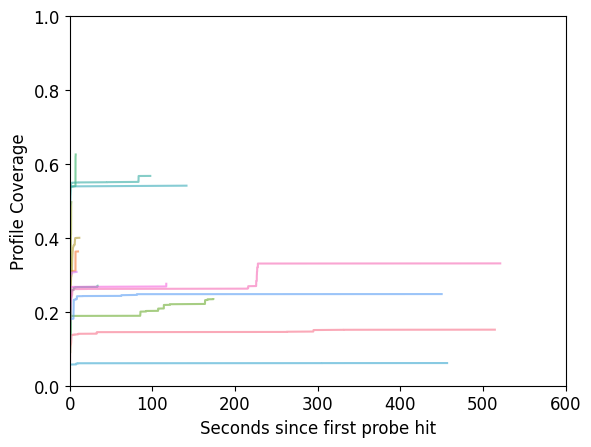

In [15]:
if "droidbot" in results_profcov:
    lineplot_max(results_profcov_precomputed_max['droidbot'], 'droidbot')

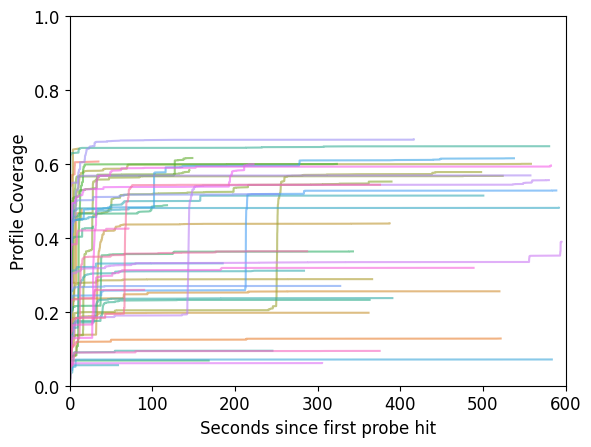

In [16]:
if "fastbot" in results_profcov:
    lineplot_max(results_profcov_precomputed_max['fastbot'], 'fastbot')

# Profile coverage over time - averages precomputed

In [17]:
# this is hacky but it works, also takes a while

PRECISION=0.2 # seconds

def precompute_averages(results):
    res = {}
    for tool in colda.TOOLS:
        if tool not in results:
            print(f"{tool} not in dataset, skipping")
            continue
        #new df to collect results 
        df = pd.DataFrame(columns=['app id', 'profile coverage', 'seconds since first probe hit'])

        # subframe with only relevant columns
        sf = results[tool][['app id','run id','profile coverage','seconds since first probe hit']].dropna()
        
        # we go slicewise through the time, starting at 0
        ps = sf[sf['seconds since first probe hit']==0] # previous_slice
        means = ps[['app id','profile coverage']].groupby('app id', as_index=False).mean()
        means.insert(1, "seconds since first probe hit", [0 for _ in range(len(means))], True)
        df = pd.concat([df, means], ignore_index=True)
        
        for i in tqdm.tqdm(np.arange(PRECISION, 600+PRECISION, PRECISION)):
            #current_slice
            cs = sf[sf['seconds since first probe hit'].between(i, i+PRECISION, inclusive='right')]
            # get max in cs
            cs = cs[['app id','run id', 'profile coverage']].groupby(['app id', 'run id'], as_index=False).max()

            # for each appid, if it is not the last entry in the run, fill in the value from the previous slide this avoids jumping in the plot when no new data was collected for a while
            # essentially we blow this up again, by first creating a df that we can check whether there will be new entries in the future
            left2process = sf[sf['seconds since first probe hit'].between(i+PRECISION, 600+PRECISION, inclusive='right')][['app id', 'run id']].drop_duplicates()

            # then we select from the previous slice all that appear in the future
            # these are things we need to potentially add to current slice
            ps = ps.merge(left2process, on=['app id', 'run id'], how='inner')[['app id', 'run id', 'profile coverage']]
            
            # merge on previous slice since it is bigger always
            cs = ps.merge(cs, on=['app id', 'run id'], how='left', indicator=True)

            # fill the NA from the previous slice (y)
            cs.loc[cs['profile coverage_y'].isnull(),'profile coverage_y'] = cs['profile coverage_x']
            cs = cs.drop(columns=['profile coverage_x', '_merge'])

            cs.columns = ['app id', 'run id', 'profile coverage']

            # grab max in slice, then mean it
            means = cs.groupby('app id', as_index=False).mean()
            means = means[['app id', 'profile coverage']]

            means.insert(1, "seconds since first probe hit", [i for _ in range(len(means))], True)
            df = pd.concat([df, means], ignore_index=True)

            ps = cs
        res[tool] = df
    return res
    
#precompute_averages(results_profcov)
results_profcov_precomputed_avg = precompute_averages(results_profcov)

100%|██████████| 3000/3000 [00:35<00:00, 84.05it/s] 


In [18]:
def lineplot_relative_precomputed(results, title):
    ax = sns.lineplot(
            x='seconds since first probe hit',
            y='profile coverage',
            hue='app id',
            data=results,
            legend=False)
    #ax.set_title(title)
    ax.set(xlim=(0,600), ylim=(0,1))
    for line in ax.lines:
        line.set_alpha(0.6)
    ax.set_xlabel("Seconds since first probe hit")
    ax.set_ylabel("Profile Coverage")
    plt.savefig(f"plots/profile-coverage_lineplot_relative_precomputed_{title}.pdf", bbox_inches='tight')
    plt.savefig(f"plots/profile-coverage_lineplot_relative_precomputed_{title}.png", bbox_inches='tight')
    plt.show()

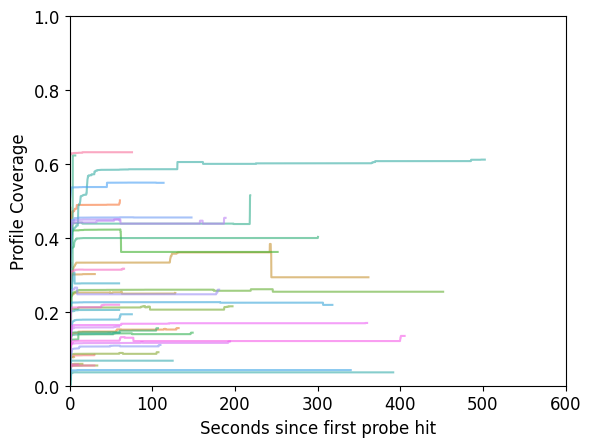

In [19]:
if "time" in results_profcov_precomputed_avg:
    lineplot_relative_precomputed(results_profcov_precomputed_avg['time'], 'avg-time')

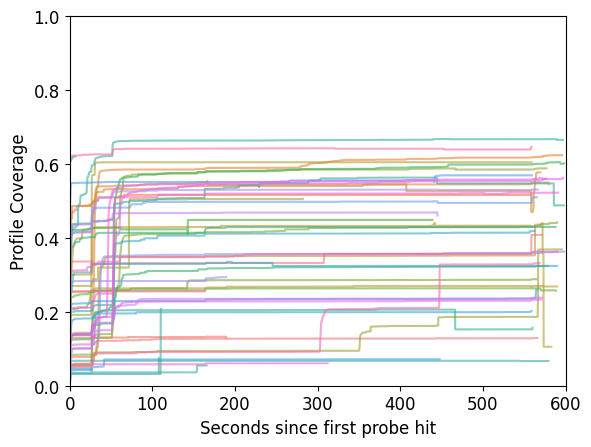

In [20]:
if "monkey" in results_profcov_precomputed_avg:
    lineplot_relative_precomputed(results_profcov_precomputed_avg['monkey'], 'avg-monkey')

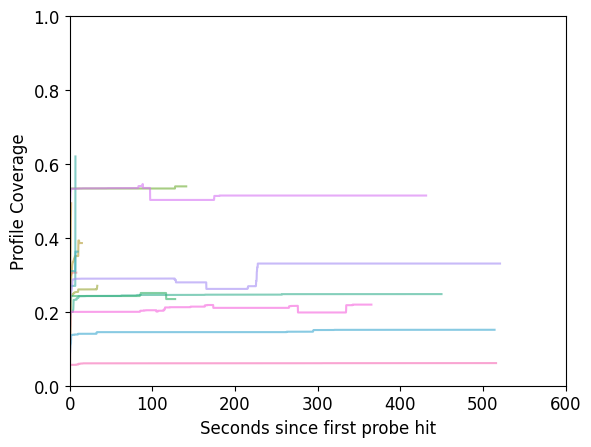

In [21]:
if "droidbot" in results_profcov_precomputed_avg:
    lineplot_relative_precomputed(results_profcov_precomputed_avg['droidbot'], 'avg-droidbot')

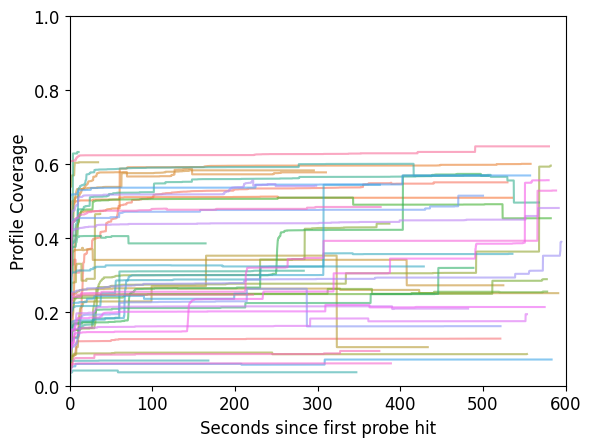

In [22]:
if "fastbot" in results_profcov_precomputed_avg:
    lineplot_relative_precomputed(results_profcov_precomputed_avg['fastbot'], 'avg-fastbot')

# comparative plots with acvtool

In [23]:
def generate_boxplot_data_profcov():
    tools = []
    appids = []
    mean_max_coverages = []
    for tool in colda.TOOLS:
        try:
            # from max values, create average
            _mmc = results_profcov[tool][['app id', 'run id', 'profile coverage']].groupby(['app id', 'run id'], as_index=False).max().groupby('app id').mean()
            mean_max_coverages.extend(list(_mmc['profile coverage']))
            appids.extend(list(_mmc.index))
            tools.extend([tool for _ in range(len(_mmc))])
        except KeyError:
            # for partial results, skip missing tool results
            pass
    
    return pd.DataFrame({'tool': tools, 'mean max coverage': mean_max_coverages, "app id": appids})

mean_max_profcov = generate_boxplot_data_profcov()

In [24]:
def generate_boxplot_data_acvtool():
    tools = []
    appids = []
    mean_max_coverages = []
    for tool in colda.TOOLS:
        try:
            _mmc = results_acvtool[tool][['app id', 'run id', 'code coverage']].groupby(['app id', 'run id'], as_index=False).max().groupby('app id').mean()
            mean_max_coverages.extend(list(_mmc['code coverage']))
            appids.extend(list(_mmc.index))
            tools.extend([tool for _ in range(len(_mmc))])
        except KeyError:
            # for partial results, skip missing tool results
            pass
        
    return pd.DataFrame({'tool': tools, 'mean max coverage': mean_max_coverages, "app id": appids})

mean_max_acvtool = generate_boxplot_data_acvtool()

In [25]:
def generate_boxplot_data_profcov_acvtool_apps_only():
    acvtool_apps_only = list(mean_max_acvtool['app id'].unique())
    return mean_max_profcov[mean_max_profcov['app id'].isin(acvtool_apps_only)]

mean_max_profcov_acvtool_apps_only = generate_boxplot_data_profcov_acvtool_apps_only()

In [26]:
def draw_stripplot(data, name, ylabel="Profile Coverage"):
    # see https://seaborn.pydata.org/examples/jitter_stripplot.html

    #sns.set_theme(style="whitegrid")
    #iris = sns.load_dataset("iris")

    # "Melt" the dataset to "long-form" or "tidy" representation
    #iris = iris.melt(id_vars="species", var_name="measurement")

    # Initialize the figure
    f, ax = plt.subplots()
    #sns.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sns.stripplot(
        data=data, x="tool", y="mean max coverage", 
        #hue="tool",
        color="#4477AA",
        dodge=True, alpha=.65, zorder=1, legend=False,
        jitter=0.25,
    )
    ax.set(ylim=(0,1))

    # Show the conditional means, aligning each pointplot in the
    # center of the strips by adjusting the width allotted to each
    # category (.8 by default) by the number of hue levels
    sns.pointplot(
        data=data, x="tool", y="mean max coverage", 
        color="#AA3377",
        #hue="tool",
        #dodge=.3 - .3 / 3,
        #palette="dark", 
        #errorbar=None,
        errorbar=("pi", 50),
        markers="_", markersize=64, linestyle="none",
    )

    # Improve the legend
    #sns.move_legend(
    #    ax, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0,
    #)
    ax.set_xticklabels(["No-Interaction","Monkey", "DroidBot", "Fastbot2"])
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")

    plt.savefig(f"plots/stripplot_{name}.pdf", bbox_inches='tight')
    plt.savefig(f"plots/stripplot_{name}.png", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_328999/3719355460.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No-Interaction","Monkey", "DroidBot", "Fastbot2"])


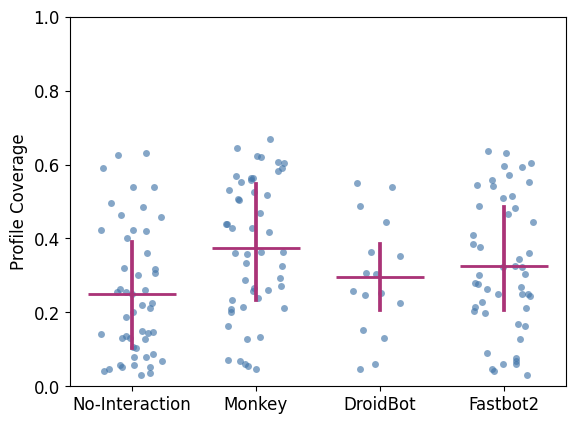

In [27]:
draw_stripplot(mean_max_profcov, "profile_coverage")

/tmp/ipykernel_328999/3719355460.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No-Interaction","Monkey", "DroidBot", "Fastbot2"])


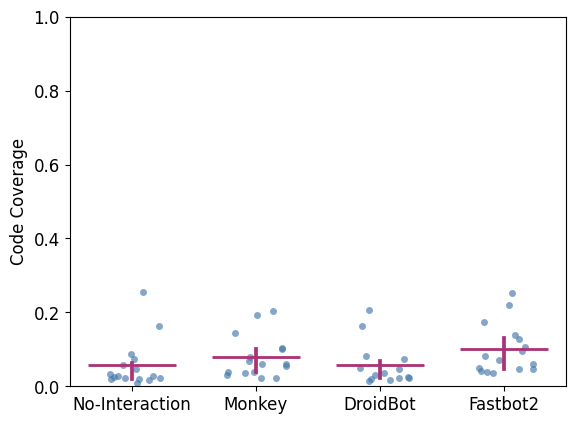

In [28]:
draw_stripplot(mean_max_acvtool, "code_coverage_acvtool", ylabel="Code Coverage")

/tmp/ipykernel_328999/3719355460.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No-Interaction","Monkey", "DroidBot", "Fastbot2"])


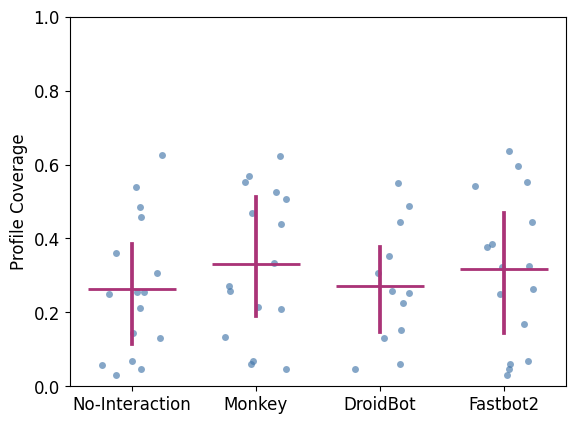

In [29]:
draw_stripplot(mean_max_profcov_acvtool_apps_only, "profile_coverage_acvtool_apps_only")

In [30]:
#mean_max_acvtool mean_max_profcov
df_mean_max_combined = pd.concat([mean_max_acvtool.assign(coverage="acvtool"), mean_max_profcov.assign(coverage="Profile")])

/tmp/ipykernel_328999/3690514735.py:29: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#AA3377'` for the same effect.

  sns.pointplot(
/tmp/ipykernel_328999/3690514735.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No-Interaction","Monkey", "DroidBot", "Fastbot2"])


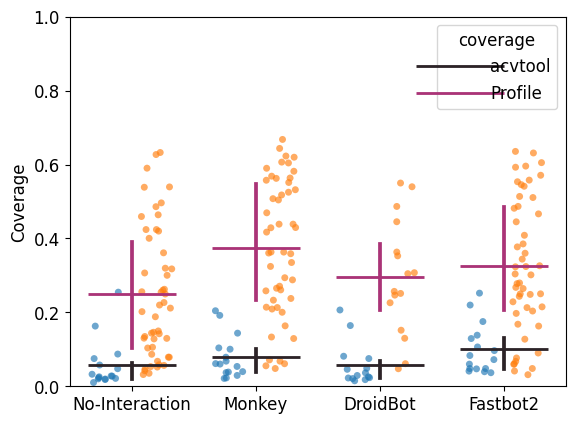

In [31]:
def draw_stripplot_combined(data, ylabel="Coverage"):
    name = "combined"
    # see https://seaborn.pydata.org/examples/jitter_stripplot.html

    #sns.set_theme(style="whitegrid")
    #iris = sns.load_dataset("iris")

    # "Melt" the dataset to "long-form" or "tidy" representation
    #iris = iris.melt(id_vars="species", var_name="measurement")

    # Initialize the figure
    f, ax = plt.subplots()
    #sns.despine(bottom=True, left=True)


    # Show each observation with a scatterplot
    sns.stripplot(
        data=data, x="tool", y="mean max coverage", 
        hue="coverage",
        #color="#4477AA",
        dodge=True, alpha=.65, zorder=1, legend=False,
        jitter=0.25,
    )
    ax.set(ylim=(0,1))

    # Show the conditional means, aligning each pointplot in the
    # center of the strips by adjusting the width allotted to each
    # category (.8 by default) by the number of hue levels
    sns.pointplot(
        data=data, x="tool", y="mean max coverage", 
        color="#AA3377",
        hue="coverage",
        #dodge=.3 - .3 / 3,
        #palette="dark", 
        #errorbar=None,
        errorbar=("pi", 50),
        markers="_", markersize=64, linestyle="none",
    )

    # Improve the legend
    #sns.move_legend(
    #    ax, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0,
    #)
    ax.set_xticklabels(["No-Interaction","Monkey", "DroidBot", "Fastbot2"])
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")

    plt.savefig(f"plots/stripplot_{name}.pdf", bbox_inches='tight')
    plt.savefig(f"plots/stripplot_{name}.png", bbox_inches='tight')
    plt.show()

draw_stripplot_combined(df_mean_max_combined)

# numbers

In [43]:
mean_max_profcov.groupby('tool').describe()

mean max coverage                                                    \
                     count      mean       std       min       25%       50%   
tool                                                                           
droidbot              16.0  0.295018  0.156351  0.047472  0.207411  0.280716   
fastbot               50.0  0.325168  0.180924  0.031326  0.205917  0.302628   
monkey                50.0  0.374527  0.183447  0.048089  0.234146  0.363133   
time                  50.0  0.248744  0.176009  0.031733  0.104088  0.215641   

                              
               75%       max  
tool                          
droidbot  0.383711  0.549876  
fastbot   0.485444  0.635472  
monkey    0.546522  0.667847  
time      0.390557  0.632488

In [42]:
mean_max_acvtool.groupby('tool').describe()

mean max coverage                                                    \
                     count      mean       std       min       25%       50%   
tool                                                                           
droidbot              14.0  0.058013  0.058211  0.014822  0.022647  0.032814   
fastbot               16.0  0.099551  0.067072  0.036702  0.047779  0.077693   
monkey                16.0  0.078380  0.057203  0.021260  0.038127  0.060707   
time                  16.0  0.056915  0.065203  0.010161  0.021006  0.027626   

                              
               75%       max  
tool                          
droidbot  0.068459  0.206406  
fastbot   0.131412  0.252012  
monkey    0.101203  0.204367  
time      0.061911  0.254641

# what about cross-correlation

In [33]:
mean_max_acvtool

,tool,mean max coverage,app id
0,time,0.025547,com.adsk.sketchbook
1,time,0.162837,com.apple.movetoios
2,time,0.027400,com.apusapps.launcher
3,time,0.057562,com.azure.authenticator
4,time,0.027852,com.blockchainvault
...,...,...,...
57,fastbot,0.072173,com.netqin.ps
58,fastbot,0.175154,com.truedevelopersstudio.automatictap.autoclicker
59,fastbot,0.036702,com.zakg.scaryteacher.hellgame
60,fastbot,0.129148,free.vpn.unblock.proxy.vpn.master.pro


In [34]:
mean_max_profcov

,tool,mean max coverage,app id
0,time,0.319500,at.ner.lepsWorld2
1,time,0.078685,com.Celltop.SpiralRoll
2,time,0.129621,com.adsk.sketchbook
3,time,0.496214,com.alpha.applock
4,time,0.149681,com.amanotes.beathopper
...,...,...,...
161,fastbot,0.060678,free.vpn.unblock.proxy.vpn.master.pro
162,fastbot,0.481676,hd.camera
163,fastbot,0.076594,io.voodoo.paper2
164,fastbot,0.249974,loseweight.weightloss.workout.fitness


In [35]:
df_corr = mean_max_acvtool.join(mean_max_profcov.set_index(['app id', 'tool']), on=['app id', 'tool'], how='inner', lsuffix='_acvtool', rsuffix='_profcov')
df_corr

,tool,mean max coverage_acvtool,app id,mean max coverage_profcov
0,time,0.025547,com.adsk.sketchbook,0.129621
1,time,0.162837,com.apple.movetoios,0.485931
2,time,0.027400,com.apusapps.launcher,0.361080
3,time,0.057562,com.azure.authenticator,0.255748
4,time,0.027852,com.blockchainvault,0.249696
5,time,0.254641,com.google.android.apps.googleassistant,0.627005
6,time,0.010161,com.ketchapp.knifehit,0.143791
7,time,0.021357,com.king.candycrushsaga,0.031733
8,time,0.023225,com.mcdonalds.mobileapp,0.067626
9,time,0.019953,com.melesta.coffeeshop,0.046856


In [36]:
for i in ['time', 'monkey', 'droidbot', 'fastbot']:
    dfc = df_corr[df_corr['tool'] == i]
    print(i)
    print(dfc['mean max coverage_acvtool'].corr(dfc['mean max coverage_profcov']))
    print()

time
0.7317927674532603

monkey
0.5018825987804444

droidbot
0.684998017874774

fastbot
0.6174112829796039



In [37]:
for i in ['time', 'monkey', 'droidbot', 'fastbot']:
    df = mean_max_profcov[mean_max_profcov['tool'] == i]['mean max coverage']
    print(i)
    print(df.describe())

time
count    50.000000
mean      0.248744
std       0.176009
min       0.031733
25%       0.104088
50%       0.215641
75%       0.390557
max       0.632488
Name: mean max coverage, dtype: float64
monkey
count    50.000000
mean      0.374527
std       0.183447
min       0.048089
25%       0.234146
50%       0.363133
75%       0.546522
max       0.667847
Name: mean max coverage, dtype: float64
droidbot
count    16.000000
mean      0.295018
std       0.156351
min       0.047472
25%       0.207411
50%       0.280716
75%       0.383711
max       0.549876
Name: mean max coverage, dtype: float64
fastbot
count    50.000000
mean      0.325168
std       0.180924
min       0.031326
25%       0.205917
50%       0.302628
75%       0.485444
max       0.635472
Name: mean max coverage, dtype: float64
